In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [82]:
mobile_modelling = pd.read_csv('../Data/Data_modelling/mobile_modelling.csv')

mean_sc_w = mobile_modelling[mobile_modelling['sc_w'] != 0]['sc_w'].mean()
mobile_modelling['sc_w'] = mobile_modelling['sc_w'].replace(0, mean_sc_w)
mobile_modelling = mobile_modelling[mobile_modelling['sc_h'] != 0]


X = mobile_modelling.iloc[:, 0:-1]
y = mobile_modelling.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

mobile_df = pd.concat([X_train, y_train], axis=1)

# variables with importance of more than 0.02 
columns_to_drop_1 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g']
X_train_r = X_train.drop(columns=columns_to_drop_1)
X_val_r = X_val.drop(columns=columns_to_drop_1)
X_test_r = X_test.drop(columns=columns_to_drop_1)


# Ensemble methods

## Stacking

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# used models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

model1 = DecisionTreeClassifier(random_state=1)
model2 = RandomForestClassifier()
model3 = SVC(random_state=1, max_iter=1000, probability=True)
model33 = SVC(random_state=1, max_iter=1000)
model4 = KNeighborsClassifier()
estimators=[('DecisionTree', model1), ('RandomForest', model2), ('SVC', model33)]
estimators1=[('RandomForest', model2), ('KNN', model4), ('SVC', model3)]
estimators2=[('DecisionTree', model1), ('RandomForest', model2),('SVC', model3), ('KNN', model4)]

### Voting Classifiers

Taking into consideration our first modelling and the results we obtained we plan to take into consideration 4 simple models that performed well on our data:
- SVC
- Decision Tree
- Random Forest Classifier
- KNN 

We will use soft voting as well as hard voting. We will also try to find the best weight combinations for chosen models combination since we think that focusing on the model with the best performance may be beneficial. We will check the results for data without removed columns and with removed columns that have feature importance greater than 0,02.

#### Hard voting

Let's see how it works for 3 models

In [42]:
model_hard = VotingClassifier(estimators=estimators, voting='hard')
model_hard.fit(X_train,y_train)
y_hat = model_hard.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_hardr = VotingClassifier(estimators=estimators, voting='hard')
model_hardr.fit(X_train_r,y_train)
y_hat = model_hardr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9013605442176871
accuracy for dataset without chosen columns:  0.8979591836734694


Now for 4 models

In [43]:
model_hard = VotingClassifier(estimators=estimators2, voting='hard')
model_hard.fit(X_train,y_train)
y_hat = model_hard.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_hardr = VotingClassifier(estimators=estimators2, voting='hard')
model_hardr.fit(X_train_r,y_train)
y_hat = model_hardr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9115646258503401
accuracy for dataset without chosen columns:  0.9081632653061225


#### Soft voting

In [44]:
model_soft = VotingClassifier(estimators=estimators1, voting='soft')
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators1, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9285714285714286
accuracy for dataset without chosen columns:  0.9285714285714286


In [45]:
model_soft = VotingClassifier(estimators=estimators2, voting='soft')
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators1, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9149659863945578
accuracy for dataset without chosen columns:  0.9285714285714286


##### Weights

In [46]:
model_soft = VotingClassifier(estimators=estimators1, voting='soft', weights=[0.2, 0.2, 0.6])
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators1, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9319727891156463
accuracy for dataset without chosen columns:  0.9217687074829932


In [47]:
model_soft = VotingClassifier(estimators=estimators1, voting='soft', weights=[0.1, 0.1, 0.80])
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators1, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9421768707482994
accuracy for dataset without chosen columns:  0.9319727891156463


In [48]:
model_soft = VotingClassifier(estimators=estimators2, voting='soft', weights=[0.1, 0.3, 0.3, 0.3])
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators2, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9285714285714286
accuracy for dataset without chosen columns:  0.9149659863945578


In [49]:
model_soft = VotingClassifier(estimators=estimators2, voting='soft', weights=[0.1, 0.2, 0.5, 0.4])
model_soft.fit(X_train,y_train)
y_hat = model_soft.predict(X_val)
print('accuracy for whole dataset: ', accuracy_score(y_val, y_hat))

model_softr = VotingClassifier(estimators=estimators2, voting='soft')
model_softr.fit(X_train_r,y_train)
y_hat = model_softr.predict(X_val_r)
print('accuracy for dataset without chosen columns: ', accuracy_score(y_val, y_hat))

accuracy for whole dataset:  0.9285714285714286
accuracy for dataset without chosen columns:  0.9149659863945578


While testing different combinations of weights for soft voting we can observe the best result for 

estimators1=[('RandomForest', model2),('KNN', model4), ('SVC', model3)]

with weights=[0.1, 0.1, 0.80].

### Stacking

We're experimenting with different combinations of base estimators and final meta-estimators within the stacking ensemble framework to determine which combination yields the best performance on the test data. We use combinations of simple models such as:
- SVC
- Decision Tree
- Random Forest Classifier
- KNN 
- Logistic Regression

In [50]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [51]:
clf = StackingClassifier(estimators=estimators1, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_val, y_val)

0.935374149659864

In [52]:
clf = StackingClassifier(estimators=estimators, final_estimator=KNeighborsClassifier())
clf.fit(X_train, y_train).score(X_val, y_val)

0.9285714285714286

In [53]:
clf = StackingClassifier(estimators=estimators2, final_estimator=KNeighborsClassifier())
clf.fit(X_train, y_train).score(X_val, y_val)

0.935374149659864

In [54]:
clf = StackingClassifier(estimators=estimators2, final_estimator=RandomForestClassifier())
clf.fit(X_train, y_train).score(X_val, y_val)

0.9625850340136054

In [55]:
clf = StackingClassifier(estimators=estimators2, final_estimator=SVC())
clf.fit(X_train, y_train).score(X_val, y_val)

0.935374149659864

We can observe the best result (accuracy = 0,976) for estimators2=[('DecisionTree', model1), ('RandomForest', model2),('SVC', model3), ('KNN', model4)] with RandomForestClassifier as a final estimator.

## Bagging (Bootstrap Aggregating)
Designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It decreases the variance and helps to avoid overfitting. It is usually applied to decision tree methods

we're testing Bagging method with two tree models - DecisionTreeClassifier and RandomForestClassifier

in 2 variants: with all the columns and with columns having importance greater than 0.02

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

In [57]:

# Creating 2 models
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42)

# Bagging for first model
bagging_model_dt = BaggingClassifier(estimator=model_dt, n_estimators=10, random_state=42)
bagging_model_dt.fit(X_train, y_train)

bagging_model_dt_r = BaggingClassifier(estimator=model_dt, n_estimators=10, random_state=42)
bagging_model_dt_r.fit(X_train_r, y_train)

# Bagging for second model
bagging_model_rf = BaggingClassifier(estimator=model_rf, n_estimators=10, random_state=42)
bagging_model_rf.fit(X_train, y_train)

bagging_model_rf_r = BaggingClassifier(estimator=model_rf, n_estimators=10, random_state=42)
bagging_model_rf_r.fit(X_train_r, y_train)

# Checking probabilities on validation datasets
probabilities_model_dt = bagging_model_dt.predict_proba(X_val)
probabilities_model_dt_r = bagging_model_dt_r.predict_proba(X_val_r)
probabilities_model_rf = bagging_model_rf.predict_proba(X_val)
probabilities_model_rf_r = bagging_model_rf_r.predict_proba(X_val_r)

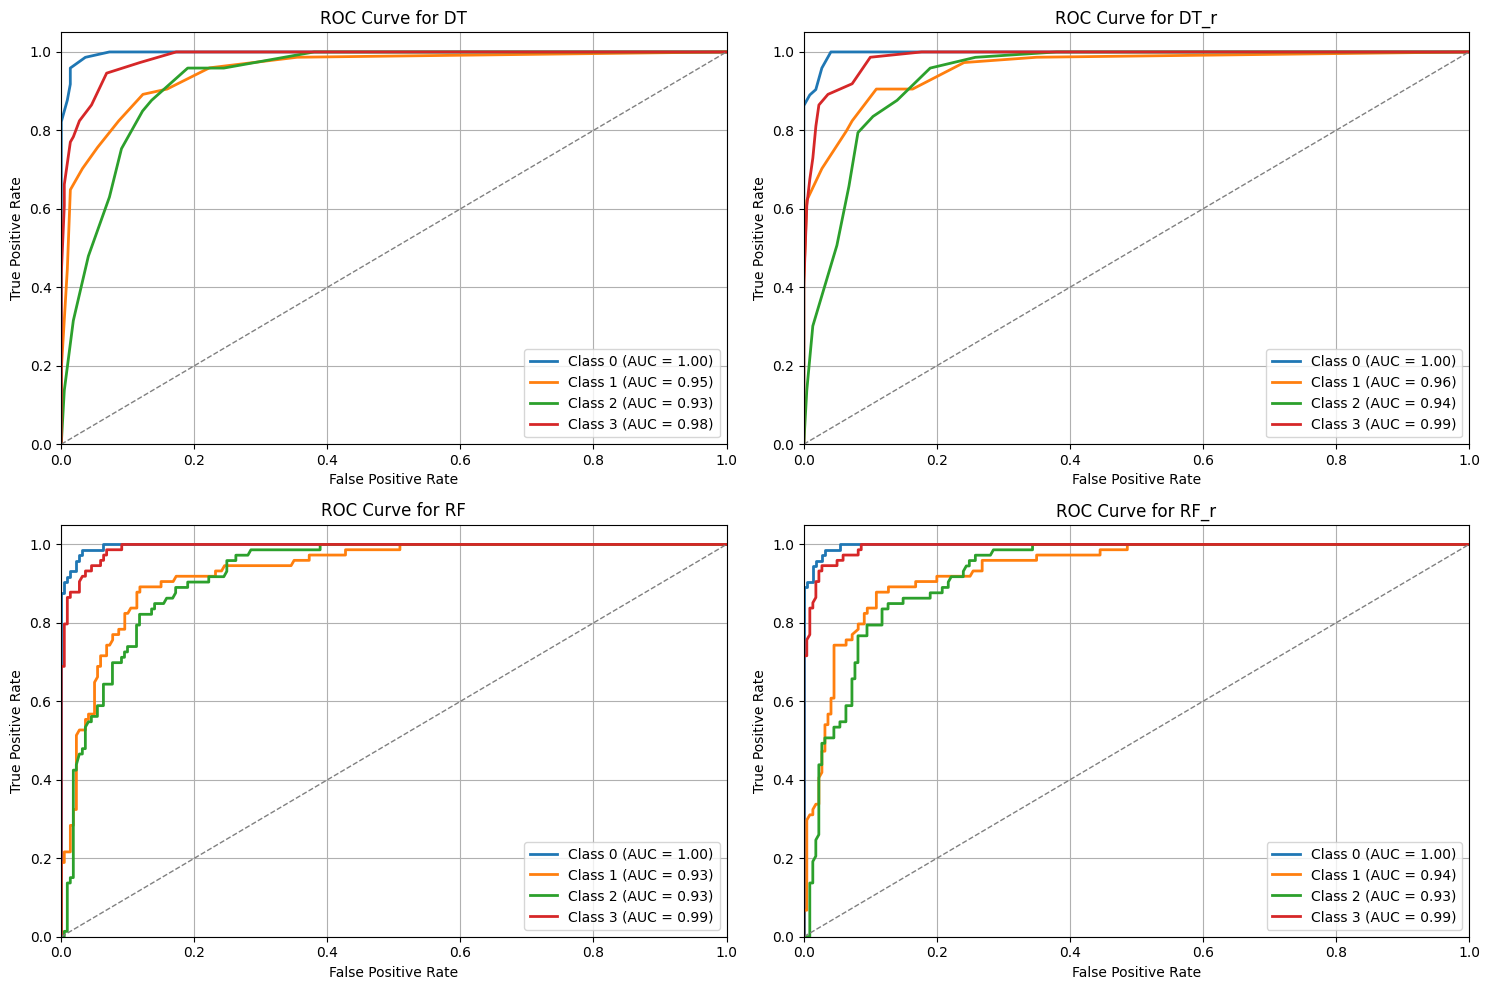

In [58]:
# Convert labels to binary format
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized.shape[1]

# Initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

models = [probabilities_model_dt, probabilities_model_dt_r, probabilities_model_rf, probabilities_model_rf_r]
model_names = ['DT', 'DT_r', 'RF', 'RF_r']

for idx, (model, model_name) in enumerate(zip(models, model_names)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], model[:, i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc='lower right')
    ax.grid(True)

plt.tight_layout()
plt.show()


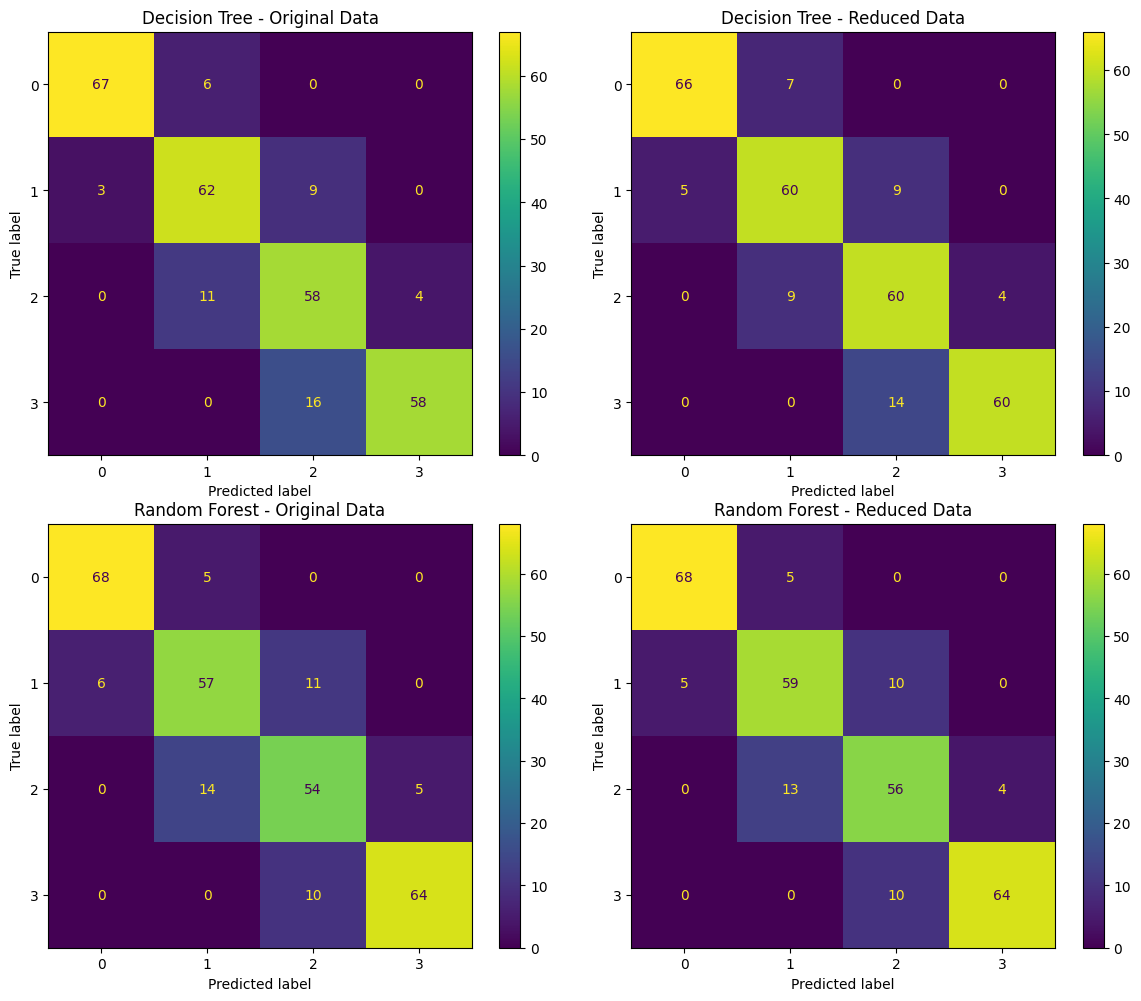

In [59]:
# Calculate confusion matrices
cm_model_dt = confusion_matrix(y_val, np.argmax(probabilities_model_dt, axis=1))
cm_model_dt_r = confusion_matrix(y_val, np.argmax(probabilities_model_dt_r, axis=1))
cm_model_rf = confusion_matrix(y_val, np.argmax(probabilities_model_rf, axis=1))
cm_model_rf_r = confusion_matrix(y_val, np.argmax(probabilities_model_rf_r, axis=1))

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_model_dt, display_labels=np.unique(y_val))
disp_dt.plot(ax=axes[0, 0])
axes[0, 0].set_title("Decision Tree - Original Data")

disp_dt_r = ConfusionMatrixDisplay(confusion_matrix=cm_model_dt_r, display_labels=np.unique(y_val))
disp_dt_r.plot(ax=axes[0, 1])
axes[0, 1].set_title("Decision Tree - Reduced Data")

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_model_rf, display_labels=np.unique(y_val))
disp_rf.plot(ax=axes[1, 0])
axes[1, 0].set_title("Random Forest - Original Data")

disp_rf_r = ConfusionMatrixDisplay(confusion_matrix=cm_model_rf_r, display_labels=np.unique(y_val))
disp_rf_r.plot(ax=axes[1, 1])
axes[1, 1].set_title("Random Forest - Reduced Data")

plt.tight_layout()
plt.show()

In [60]:
predictions_model_dt = bagging_model_dt.predict(X_val)
predictions_model_dt_r = bagging_model_dt_r.predict(X_val_r)
predictions_model_rf = bagging_model_rf.predict(X_val)
predictions_model_rf_r = bagging_model_rf_r.predict(X_val_r)

# Printing classification report
print("Bagging with DecisionTreeClassifier - all columns")
print(classification_report(y_val, predictions_model_dt))

print("Bagging with DecisionTreeClassifier - important columns")
print(classification_report(y_val, predictions_model_dt_r))

print("\nBagging with RandomForestClassifier - all columns")
print(classification_report(y_val, predictions_model_rf))

print("\nBagging with RandomForestClassifier - important columns")
print(classification_report(y_val, predictions_model_rf_r))

Bagging with DecisionTreeClassifier - all columns
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        73
           1       0.78      0.84      0.81        74
           2       0.70      0.79      0.74        73
           3       0.94      0.78      0.85        74

    accuracy                           0.83       294
   macro avg       0.84      0.83      0.84       294
weighted avg       0.84      0.83      0.84       294

Bagging with DecisionTreeClassifier - important columns
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        73
           1       0.79      0.81      0.80        74
           2       0.72      0.82      0.77        73
           3       0.94      0.81      0.87        74

    accuracy                           0.84       294
   macro avg       0.84      0.84      0.84       294
weighted avg       0.84      0.84      0.84       294


Bagging with RandomFore

## Boosting
we're checking Boosting method with:
    AdaBoost
    XGBoost
    CatBoost

in 2 variants: with all the columns and with columns having importance greater than 0.02

In [61]:
#!pip install xgboost
#!pip install catboost

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [64]:
# Function for training and evaluating the model
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print(classification_report(y_val, predictions))

# Modeling with AdaBoost for all columns
print("AdaBoost for all columns:")
ada_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
train_and_evaluate_model(ada_model, X_train, X_test, y_train, y_test)

# Modeling with AdaBoost for selected columns
print("\nAdaBoost for selected columns:")
train_and_evaluate_model(ada_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with XGBoost for all columns
print("\nXGBoost for all columns:")
xgb_model = XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

# Modeling with XGBoost for selected columns
print("\nXGBoost for selected columns:")
train_and_evaluate_model(xgb_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with CatBoost for all columns
# print("\nCatBoost for all columns:")
# cat_model = CatBoostClassifier(random_state=42, verbose=0)
# train_and_evaluate_model(cat_model, X_train, X_test, y_train, y_test)

# # Modeling with CatBoost for selected columns
# print("\nCatBoost for selected columns:")
# train_and_evaluate_model(cat_model, X_train_r, X_val_r, y_train, y_val)


AdaBoost for all columns:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81        32
           1       0.66      0.68      0.67        31
           2       0.40      0.72      0.52        32
           3       0.33      0.13      0.19        31

    accuracy                           0.56       126
   macro avg       0.58      0.56      0.54       126
weighted avg       0.58      0.56      0.55       126


AdaBoost for selected columns:


              precision    recall  f1-score   support

           0       0.88      0.58      0.69        73
           1       0.60      0.74      0.67        74
           2       0.41      0.68      0.52        73
           3       0.41      0.19      0.26        74

    accuracy                           0.55       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.58      0.55      0.53       294


XGBoost for all columns:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.87      0.87      0.87        31
           2       0.91      0.91      0.91        32
           3       0.97      1.00      0.98        31

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126


XGBoost for selected columns:
              precision    recall  f1-score   support

           0      

### Boosting methods with visualisations

AdaBoost for all columns:
              precision    recall  f1-score   support

           0       0.88      0.58      0.69        73
           1       0.60      0.74      0.67        74
           2       0.41      0.68      0.52        73
           3       0.41      0.19      0.26        74

    accuracy                           0.55       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.58      0.55      0.53       294



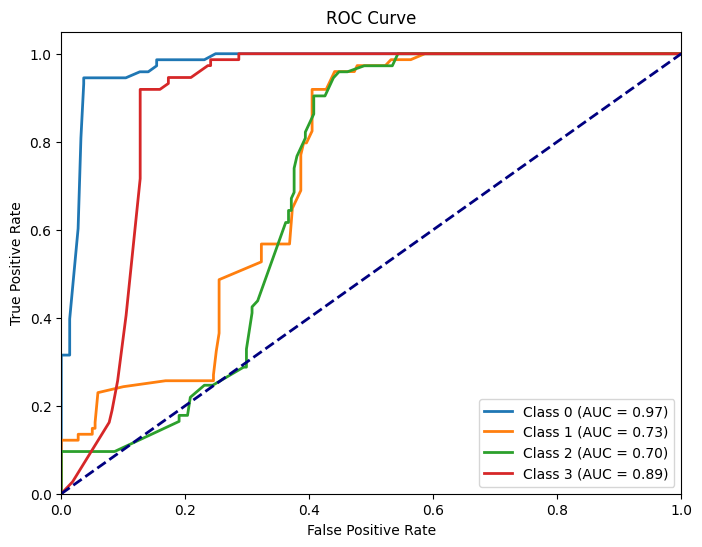

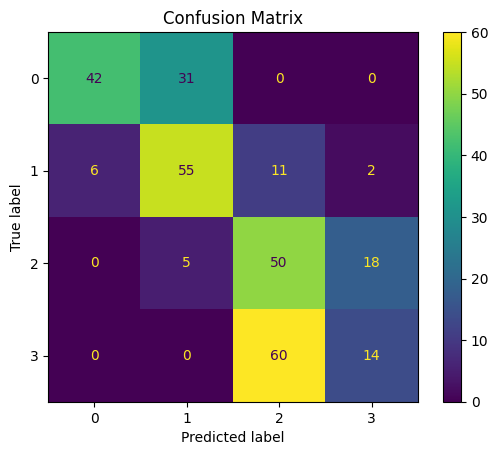


AdaBoost for selected columns:
              precision    recall  f1-score   support

           0       0.88      0.58      0.69        73
           1       0.60      0.74      0.67        74
           2       0.41      0.68      0.52        73
           3       0.41      0.19      0.26        74

    accuracy                           0.55       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.58      0.55      0.53       294



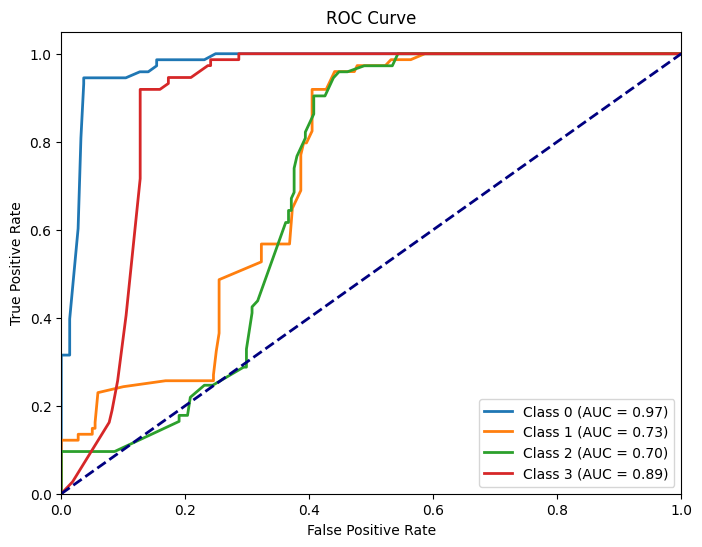

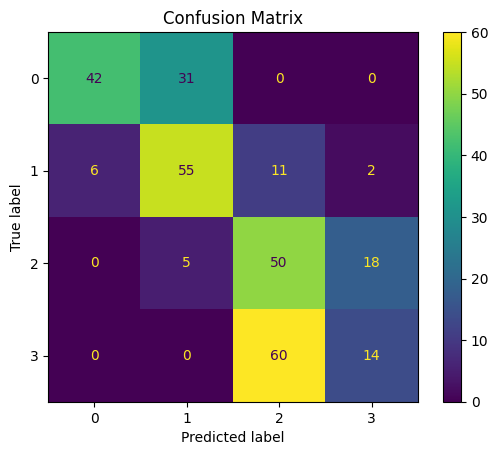


XGBoost for all columns:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        73
           1       0.86      0.88      0.87        74
           2       0.85      0.86      0.86        73
           3       0.96      0.93      0.95        74

    accuracy                           0.90       294
   macro avg       0.91      0.90      0.91       294
weighted avg       0.91      0.90      0.91       294



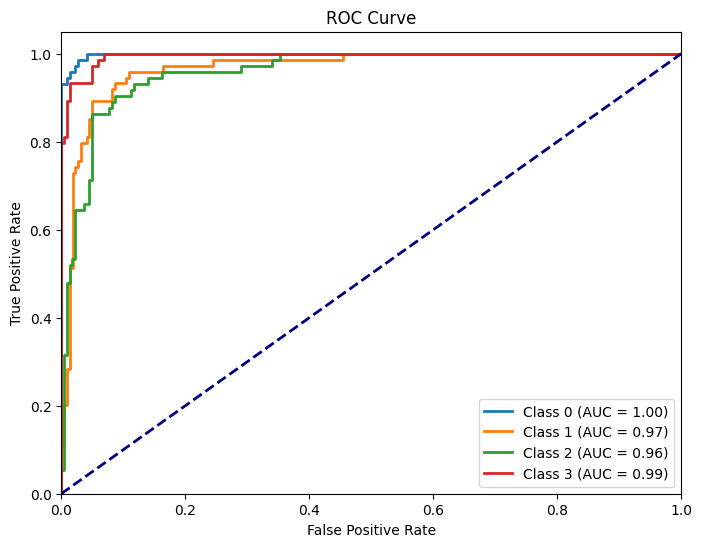

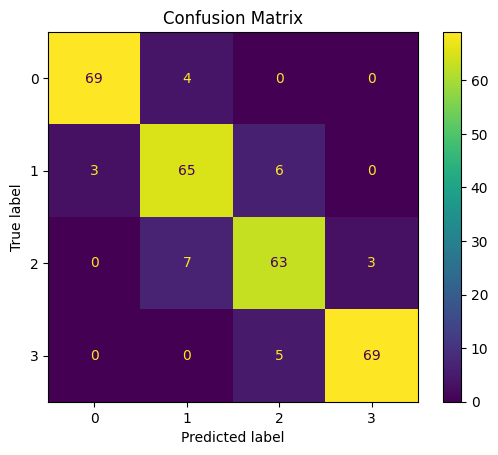


XGBoost for selected columns:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        73
           1       0.86      0.88      0.87        74
           2       0.84      0.85      0.84        73
           3       0.95      0.93      0.94        74

    accuracy                           0.90       294
   macro avg       0.90      0.90      0.90       294
weighted avg       0.90      0.90      0.90       294



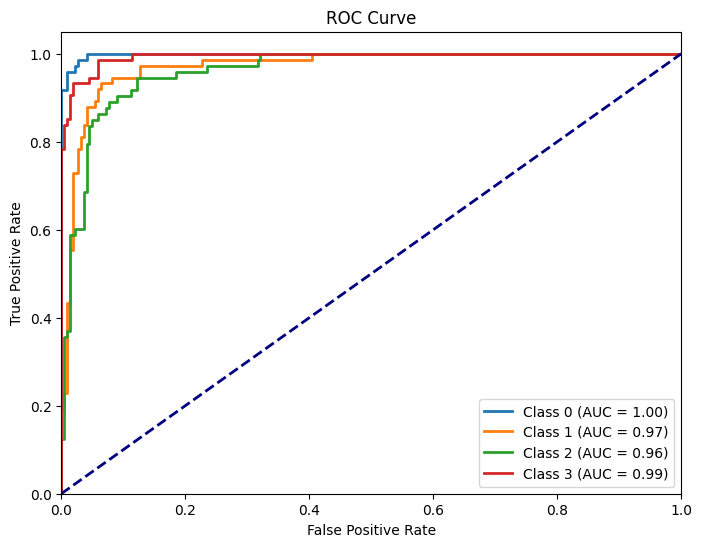

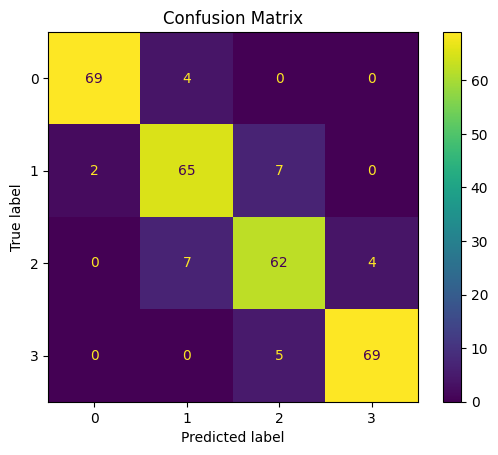

In [65]:
# Function for training, evaluating the model, and plotting ROC curve
def train_and_evaluate_model_with_ROC(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print(classification_report(y_val, predictions))
    
    # Binarize the labels for ROC curve
    if len(np.unique(y_train)) > 2:
        y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
        y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
    else:
        y_train_bin = y_train
        y_val_bin = y_val

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if len(np.unique(y_train)) > 2:
        for i in range(len(np.unique(y_train))):
            fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], model.predict_proba(X_val)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr, tpr, _ = roc_curve(y_val_bin, model.predict_proba(X_val)[:, 1])
        roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    if len(np.unique(y_train)) > 2:
        for i in range(len(np.unique(y_train))):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    else:
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:0.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

# Modeling with AdaBoost for all columns
print("AdaBoost for all columns:")
ada_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
train_and_evaluate_model_with_ROC(ada_model, X_train, X_val, y_train, y_val)

# Modeling with AdaBoost for selected columns
print("\nAdaBoost for selected columns:")
train_and_evaluate_model_with_ROC(ada_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with XGBoost for all columns
print("\nXGBoost for all columns:")
xgb_model = XGBClassifier(random_state=42)
train_and_evaluate_model_with_ROC(xgb_model, X_train, X_val, y_train, y_val)

# Modeling with XGBoost for selected columns
print("\nXGBoost for selected columns:")
train_and_evaluate_model_with_ROC(xgb_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with CatBoost for all columns
# print("\nCatBoost for all columns:")
# cat_model = CatBoostClassifier(random_state=42, verbose=0)
# train_and_evaluate_model_with_ROC(cat_model, X_train, X_test, y_train, y_test)

# # Modeling with CatBoost for selected columns
# print("\nCatBoost for selected columns:")
# train_and_evaluate_model_with_ROC(cat_model, X_train_r, X_val_r, y_train, y_val)


### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
weights=['uniform', 'distance']
n_neighbors=[1, 3, 5]
param_grid = dict(weights=weights, n_neighbors=n_neighbors)

knn= KNeighborsClassifier()
grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 10, scoring=['accuracy', 'roc_auc_ovo_weighted', 'f1_weighted'], n_jobs=-1, refit='accuracy')
grid_result = grid.fit(X_train, y_train)
print("KNN - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

KNN - Best: 0.911224 using {'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
kernel=['linear', 'rbf']
C=[0.5, 1, 5, 20]
gamma=[0.5, 1, 5, 10]
param_grid = dict(kernel=kernel, C=C, gamma=gamma)

svm= SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv = 5, scoring=['accuracy', 'roc_auc_ovo_weighted', 'f1_weighted'], n_jobs=-1, refit='accuracy')
grid_result = grid.fit(X_train, y_train)
print("SVM - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

SVM - Best: 0.970408 using {'C': 1, 'gamma': 0.5, 'kernel': 'linear'}


In [ ]:
kernel=['linear', 'rbf']
C=[0.5, 1, 5, 20]
gamma=[0.5, 1, 5, 10]
param_grid = dict(kernel=kernel, C=C, gamma=gamma)

svm= SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv = 5, scoring=['accuracy', 'roc_auc_ovo_weighted', 'f1_weighted'], n_jobs=-1, refit='accuracy')
grid_result = grid.fit(X_train_r, y_train)
print("SVM - not all columns - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

SVM - not all columns - Best: 0.965306 using {'C': 5, 'gamma': 0.5, 'kernel': 'linear'}


In [ ]:
from xgboost import XGBClassifier

max_depth = [3, 4, 5, 7]
n_estimators = [50, 75, 100, 150, 200]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
param_grid = dict(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate)

xgb_model = XGBClassifier()
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)
print("XGBoost - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


XGBoost - Best: 0.883673 using {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 200}


### Bayes optimization

In [ ]:
#! pip install scikit-optimize

#### SVM

In [ ]:
from skopt import BayesSearchCV
from sklearn.svm import SVC

opt = BayesSearchCV(
    SVC(),
    {
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("best score on train set: %s" % opt.best_score_)
print("score on validation set: %s" % opt.score(X_val, y_val))

best score on train set: 0.9653070924247825
score on validation set: 0.9693877551020408


#### Random Forest Classifier

In [ ]:
# Define the optimizer with BayesSearchCV
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': (10, 1000),  # Number of trees in the forest
        'max_depth': (1, 20),  # Maximum depth of the tree
        'min_samples_split': (2, 10),  # Minimum number of samples required to split a node
        'min_samples_leaf': (1, 10),  # Minimum number of samples required at each leaf node
        'max_features': (1, len(X_train.columns)),  # Number of features to consider when looking for the best split
    },
    n_iter=10,  # Number of optimization iterations
    cv=3
)

# Fit the optimizer to the training data
opt_rf.fit(X_train, y_train)

# Print the best validation score for Random Forest
print("best score on train set: %s" % opt_rf.best_score_)

# Print the test score for Random Forest
print("score on validation set: %s" % opt_rf.score(X_val, y_val))

best score on train set: 0.8530921871384528
score on validation set: 0.8571428571428571


#### Decision Tree Classifier

In [ ]:
# Define the optimizer with BayesSearchCV
opt_dt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1, 20),  # Maximum depth of the tree
        'min_samples_split': (2, 10),  # Minimum number of samples required to split a node
        'min_samples_leaf': (1, 10),  # Minimum number of samples required at each leaf node
        'max_features': (1, len(X_train.columns)),  # Number of features to consider when looking for the best split
    },
    n_iter=10,  # Number of optimization iterations
    cv=3
)

# Fit the optimizer to the training data
opt_dt.fit(X_train, y_train)

# Print the best validation score for Decision Tree
print("best score on train set: %s" % opt_dt.best_score_)

# Print the test score for Decision Tree
print("score on validation set: %s" % opt_dt.score(X_val, y_val))

best score on train set: 0.8051099729210834
score on validation set: 0.8231292517006803


#### XGBoost

In [ ]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier

opt = BayesSearchCV(
    XGBClassifier(),
    {
        'max_depth': (3, 10),  # integer valued parameter
        'learning_rate': (0.01, 1.0, 'log-uniform'),  # continuous parameter
        'n_estimators': (100, 1000),  # integer valued parameter
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("best score on train set: %s" % opt.best_score_)
print("score on validation set: %s" % opt.score(X_val, y_val))


best score on train set: 0.8775663996297757
score on validation set: 0.9013605442176871


# AutoML

### TPOT

In [ ]:
#!pip install tpot

In [71]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=30, verbosity=2)
tpot.fit(X_train, y_train)

print(tpot.score(X_val, y_val))

#tpot.export('tpot_best_pipeline.py')

Optimization Progress:   0%|          | 0/180 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9020408163265307

Generation 2 - Current best internal CV score: 0.9061224489795918

Generation 3 - Current best internal CV score: 0.9061224489795918

Generation 4 - Current best internal CV score: 0.9142857142857143

Generation 5 - Current best internal CV score: 0.9142857142857143

Best pipeline: KNeighborsClassifier(Nystroem(input_matrix, gamma=1.0, kernel=polynomial, n_components=7), n_neighbors=28, p=2, weights=uniform)
0.9285714285714286


According to the results the best solution would be LogisticRegression(RobustScaler(ZeroCount(MaxAbsScaler(input_matrix))), C=25.0, dual=False, penalty=l2) which might be surprising since when testing this model earlier we observed rather unsatisfactory results. Of course, the proposed one has a lot of additional changes and modifications.

# Parameters tuning

The models that gave the best results so far are:
- SVM 
- XGBoost
- Stacking where estimators2=[('DecisionTree', model1), ('RandomForest', model2),('SVC', model3), ('KNN', model4)] with KNeighborsClassifier as a final estimator
- modified Logistic Regression (we already have paramteres we shoul use)

So for the first three we will try to find the best hyperparameters and see what results we can get.

### GridSearchCV

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [73]:
kernel=['linear', 'rbf']
C=[0.5, 1, 5, 20]
gamma=[0.5, 1, 5, 10]
param_grid = dict(kernel=kernel, C=C, gamma=gamma)

svm= SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv = 5, scoring=['accuracy', 'roc_auc_ovo_weighted', 'f1_weighted'], n_jobs=-1, refit='accuracy')
grid_result = grid.fit(X_train, y_train)
print("SVM - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

SVM - Best: 0.969388 using {'C': 0.5, 'gamma': 0.5, 'kernel': 'linear'}


In [74]:
kernel=['linear', 'rbf']
C=[0.5, 1, 5, 20]
gamma=[0.5, 1, 5, 10]
param_grid = dict(kernel=kernel, C=C, gamma=gamma)

svm= SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv = 5, scoring=['accuracy', 'roc_auc_ovo_weighted', 'f1_weighted'], n_jobs=-1, refit='accuracy')
grid_result = grid.fit(X_train_r, y_train)
print("SVM - not all columns - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

SVM - not all columns - Best: 0.967347 using {'C': 5, 'gamma': 0.5, 'kernel': 'linear'}


In [75]:
from xgboost import XGBClassifier

max_depth = [3, 4, 5, 7]
n_estimators = [50, 75, 100, 150, 200]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
param_grid = dict(max_depth=max_depth, n_estimators = n_estimators, learning_rate=learning_rate)

xgb_model = XGBClassifier()
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)
print("XGBoost - Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


XGBoost - Best: 0.883673 using {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 200}


### Bayes optimization

In [ ]:
#! pip install scikit-optimize

#### SVM

In [76]:
from skopt import BayesSearchCV
from sklearn.svm import SVC

opt = BayesSearchCV(
    SVC(),
    {
        'degree': (1, 8), 
        'kernel': ['linear', 'poly', 'rbf'], 
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("best score on train set: %s" % opt.best_score_)
print("score on validation set: %s" % opt.score(X_val, y_val))
print("Best parameters: ")
print(opt.best_params_)

best score on train set: 0.9632652295454118
score on validation set: 0.9795918367346939
Best parameters: 
OrderedDict([('degree', 3), ('kernel', 'linear')])


#### XGBoost

In [77]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier

opt = BayesSearchCV(
    XGBClassifier(),
    {
        'max_depth': (3, 10),  # integer valued parameter
        'learning_rate': (0.01, 1.0, 'log-uniform'),  # continuous parameter
        'n_estimators': (100, 1000),  # integer valued parameter
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("best score on train set: %s" % opt.best_score_)
print("score on validation set: %s" % opt.score(X_val, y_val))
print("Best parameters: ")
print(opt.best_params_)


best score on train set: 0.8775757803168172
score on validation set: 0.8945578231292517
Best parameters: 
OrderedDict([('learning_rate', 0.41538661579429303), ('max_depth', 8), ('n_estimators', 398)])


# Chosing a model

Let's take a look at the three models that in our opinion are the best:
- SVM 
- Stacking where estimators2=[('DecisionTree', model1), ('RandomForest', model2),('SVC', model3), ('KNN', model4)] with KNeighborsClassifier as a final estimator
- modified Logistic Regression (we already have paramteres we shoul use)

#### SVM

SVM for all columns:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.97      0.97      0.97        74
           2       0.97      0.97      0.97        73
           3       0.99      0.99      0.99        74

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294



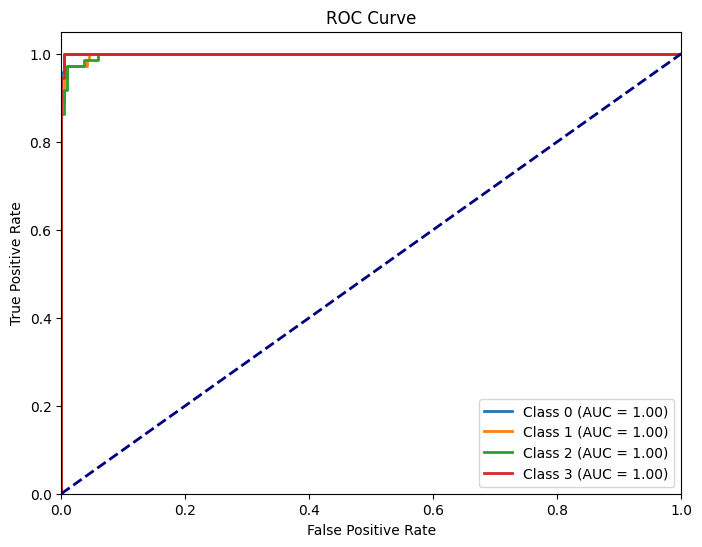

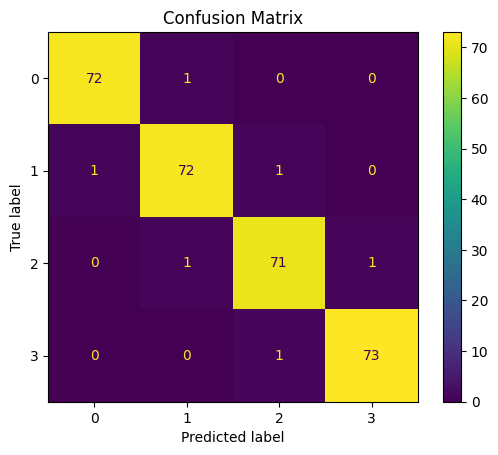

SVM with removed columns:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.97      0.96      0.97        74
           2       0.96      0.97      0.97        73
           3       0.99      0.99      0.99        74

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294



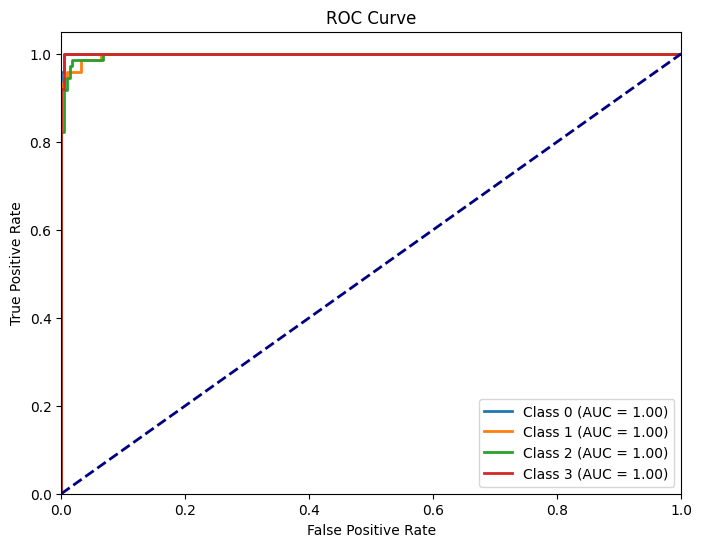

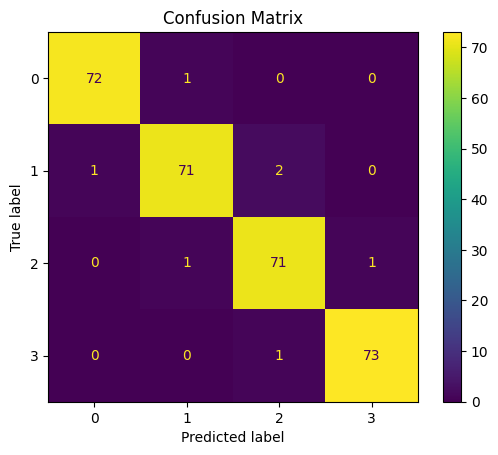

In [103]:
svm_final = SVC(gamma=0.5, C=1, kernel='linear', probability=True, degree=3)
svm_final_r = SVC(gamma=0.5, C=1, kernel='linear', probability=True, degree=3)

print("SVM for all columns:")
train_and_evaluate_model_with_ROC(svm_final, X_train, X_val, y_train, y_val)

print("SVM with removed columns:")
train_and_evaluate_model_with_ROC(svm_final_r, X_train_r, X_val_r, y_train, y_val)

#### Stacking

StackingClassifier for all columns:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.97      0.96      0.97        74
           2       0.97      0.96      0.97        73
           3       0.97      1.00      0.99        74

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294



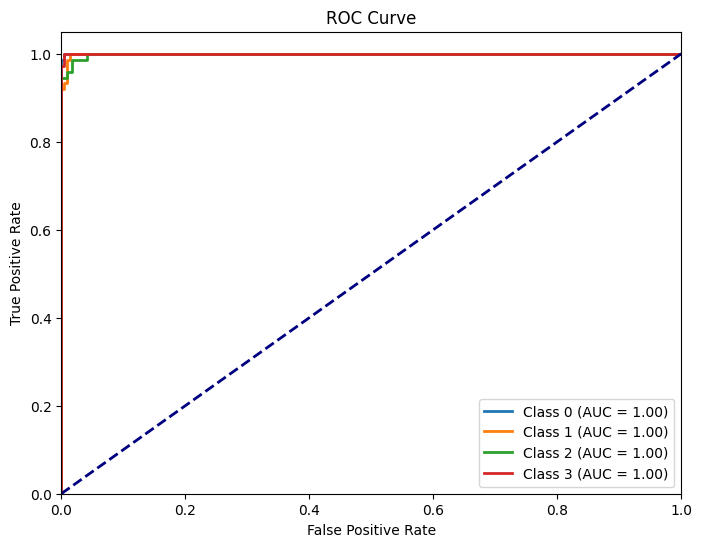

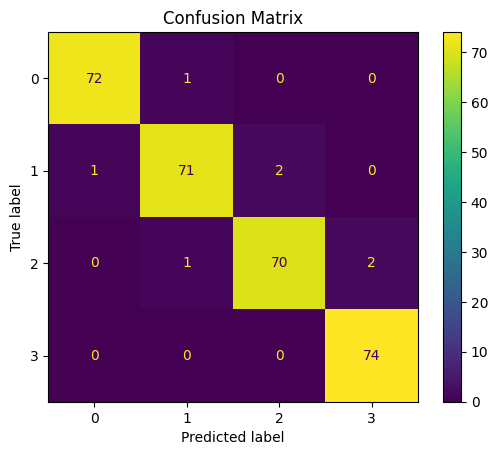

StackingClassifier with removed columns:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.97      0.96      0.97        74
           2       0.96      0.97      0.97        73
           3       0.99      0.99      0.99        74

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294



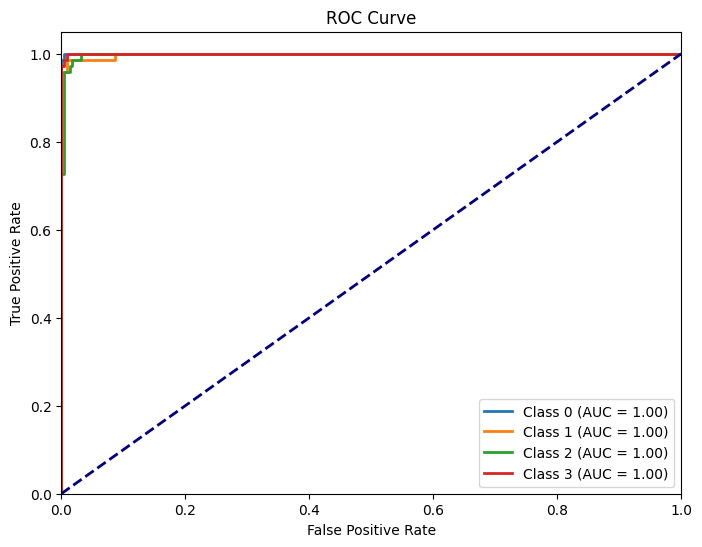

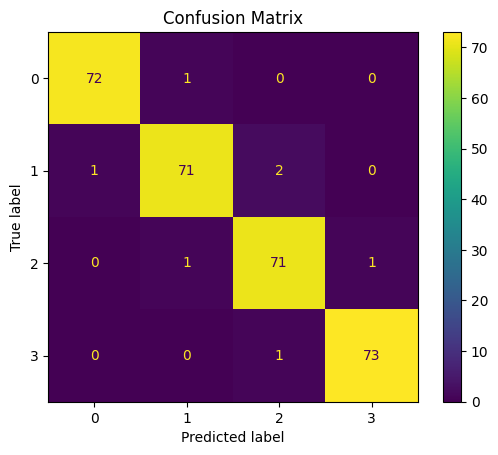

In [104]:
model1 = DecisionTreeClassifier(max_depth=9, max_features=18, min_samples_leaf=8, min_samples_split=6)
model2 = RandomForestClassifier(max_depth=14, max_features=14, min_samples_leaf=4, min_samples_split=6, n_estimators=136)
model4 = KNeighborsClassifier()
estimators_f = [('DecisionTree', model1), ('RandomForest', model2),('SVC', svm_final), ('KNN', model4)]
clf_final = StackingClassifier(estimators=estimators_f, final_estimator=model2)
clf_final_r = StackingClassifier(estimators=estimators_f, final_estimator=model2)

print("StackingClassifier for all columns:")
train_and_evaluate_model_with_ROC(clf_final, X_train, X_val, y_train, y_val)

print("StackingClassifier with removed columns:")
train_and_evaluate_model_with_ROC(clf_final_r, X_train_r, X_val_r, y_train, y_val)

#### Logistic Regression

Logistic Regression for all columns:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.93      0.95      0.94        74
           2       0.96      0.92      0.94        73
           3       0.97      1.00      0.99        74

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294



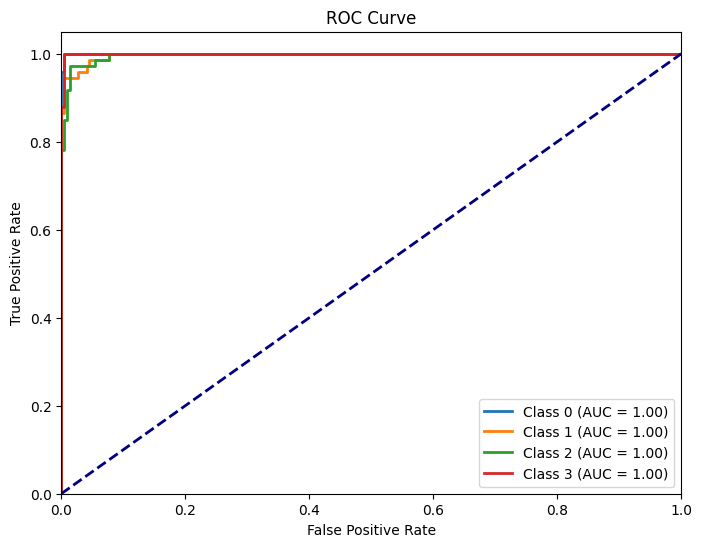

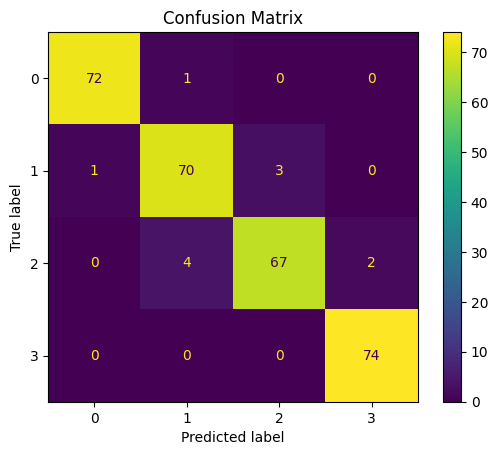

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', Pipeline(steps=[
            ('max_abs_scaler', MaxAbsScaler()),
            ('zero_count', FunctionTransformer(func=lambda X: np.where(X == 0, np.nan, X))),
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust_scaler', RobustScaler())
        ]), X_train.columns)
    ])

# Define the logistic regression model
logistic_model = LogisticRegression(C=25.0, dual=False, penalty='l2')

# Combine preprocessing and modeling into a single pipeline
pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', logistic_model)])


print("Logistic Regression for all columns:")
train_and_evaluate_model_with_ROC(pipeline_final, X_train, X_val, y_train, y_val)

#### Test dataset performance

Now let's see their performance on test dataset.

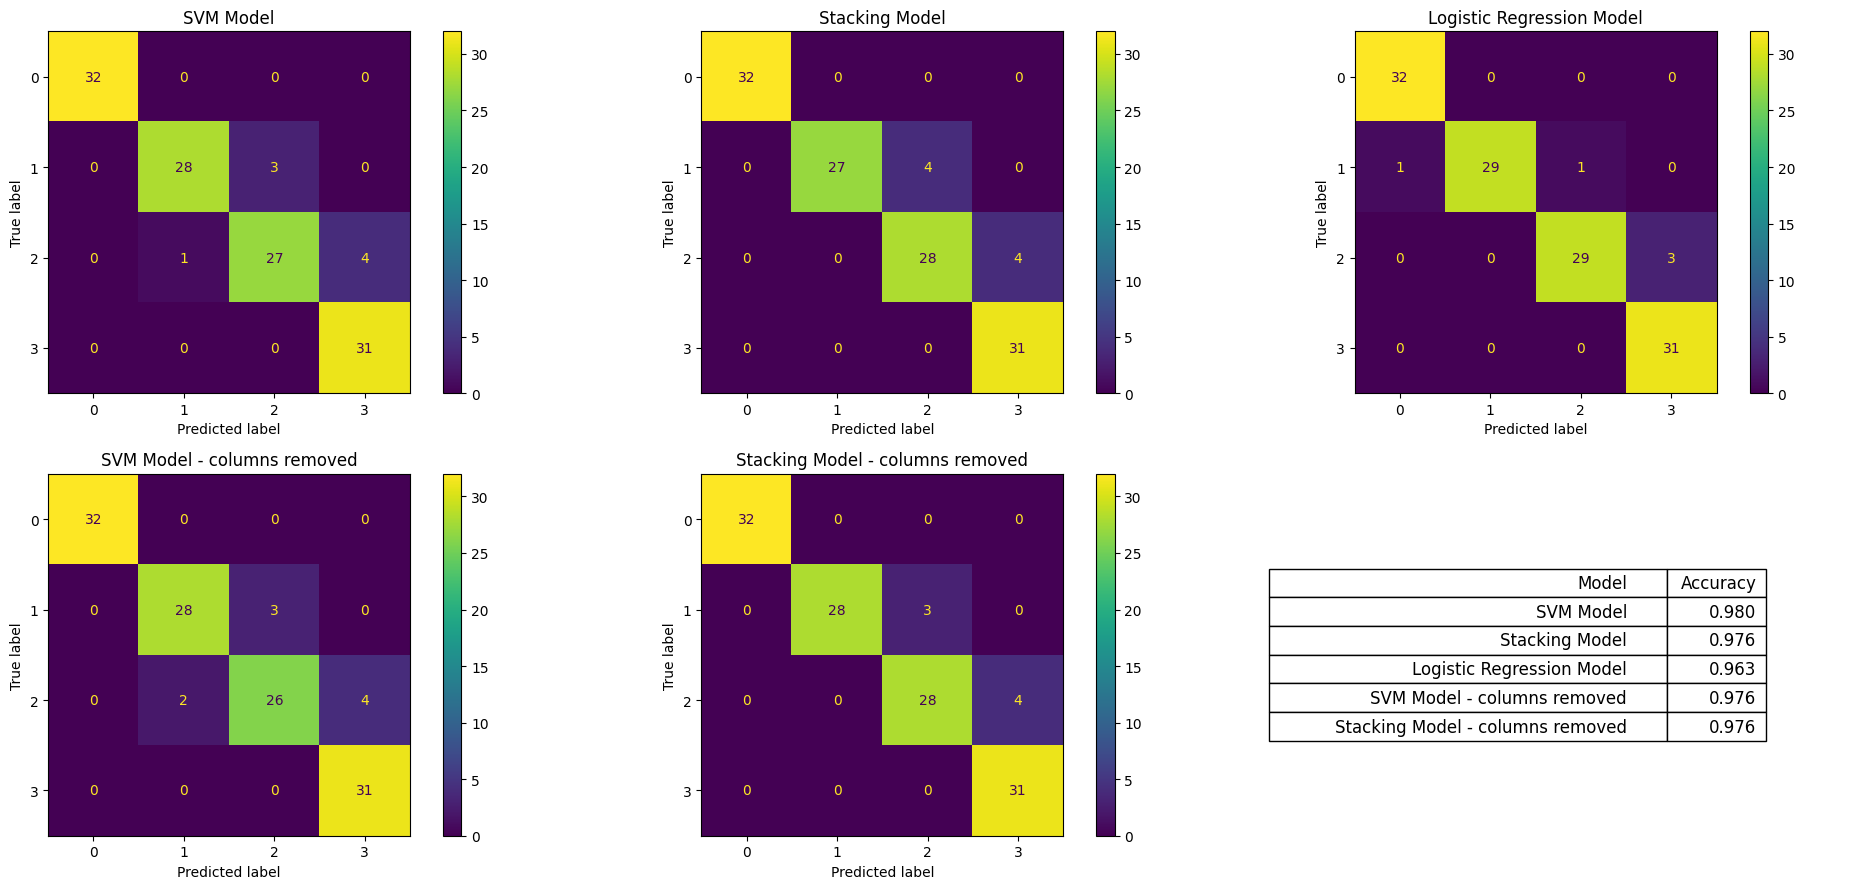

In [131]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each model
accuracy_model_1 = accuracy_score(y_val, svm_final.predict(X_val))
accuracy_model_2 = accuracy_score(y_val, clf_final.predict(X_val))
accuracy_model_3 = accuracy_score(y_val, pipeline_final.predict(X_val))
accuracy_model_4 = accuracy_score(y_val, svm_final_r.predict(X_val_r))
accuracy_model_5 = accuracy_score(y_val, clf_final_r.predict(X_val_r))

# Create a table with model names and accuracies
model_names = ['SVM Model', 'Stacking Model', 'Logistic Regression Model', 
               'SVM Model - columns removed', 'Stacking Model - columns removed']
accuracies = [accuracy_model_1, accuracy_model_2, accuracy_model_3, 
              accuracy_model_4, accuracy_model_5]

# Plot confusion matrices and accuracy table
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

disp_model_1 = ConfusionMatrixDisplay(confusion_matrix=cm_model_1, display_labels=np.unique(y_val))
disp_model_1.plot(ax=axes[0,0])
axes[0,0].set_title('SVM Model')

disp_model_2 = ConfusionMatrixDisplay(confusion_matrix=cm_model_2, display_labels=np.unique(y_val))
disp_model_2.plot(ax=axes[0,1])
axes[0,1].set_title('Stacking Model')

disp_model_3 = ConfusionMatrixDisplay(confusion_matrix=cm_model_3, display_labels=np.unique(y_val))
disp_model_3.plot(ax=axes[0,2])
axes[0,2].set_title('Logistic Regression Model')

disp_model_4 = ConfusionMatrixDisplay(confusion_matrix=cm_model_4, display_labels=np.unique(y_val))
disp_model_4.plot(ax=axes[1,0])
axes[1,0].set_title('SVM Model - columns removed')

disp_model_5 = ConfusionMatrixDisplay(confusion_matrix=cm_model_5, display_labels=np.unique(y_val))
disp_model_5.plot(ax=axes[1,1])
axes[1,1].set_title('Stacking Model - columns removed')

# Plot accuracy table
table_data = [['Model', 'Accuracy']]
table_data.extend([[model_names[i], f'{accuracies[i]:.3f}'] for i in range(len(model_names))])

table_ax = axes[1, 2:]
table_ax[0].axis('off')
table = table_ax[0].table(cellText=table_data, loc='center', colWidths=[0.4, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.tight_layout()
plt.show()


Podejmiemy decyzje po walidacji i guess ale pewnie finalnie wybierzemy to albo ewentualnie SVM bo jest prosty a daje nawet ok rezultaty.

# XAI

We can take a look on how chosen models make decisions and predictions.

In [ ]:
#!pip install lime
#!pip install pdpbox

In [ ]:
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
from sklearn .inspection import PartialDependenceDisplay
from sklearn.svm import SVC

svm = SVC(gamma=0.5, C=1, kernel='linear', probability=True, degree=8)
svm.fit(X_train, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode='classification',
                                                   feature_names=X_train.columns.tolist(),
                                                   class_names=y_train.unique(),
                                                   discretize_continuous=True)

# Przygotowanie pojedynczej obserwacji do analizy
observation = X_val.values[42]

# Wyjaśnienie predykcji modelu SVC
predictions = svm.predict_proba([observation])
classifier_fn = lambda x: predictions
explanation = explainer.explain_instance(data_row=observation, predict_fn=svm.predict_proba, num_features=len(X_train.columns),  top_labels=len(y_train.unique()))

# Wyświetlenie wyjaśnienia LIME
explanation.show_in_notebook()


/Users/Karolina/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/Karolina/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


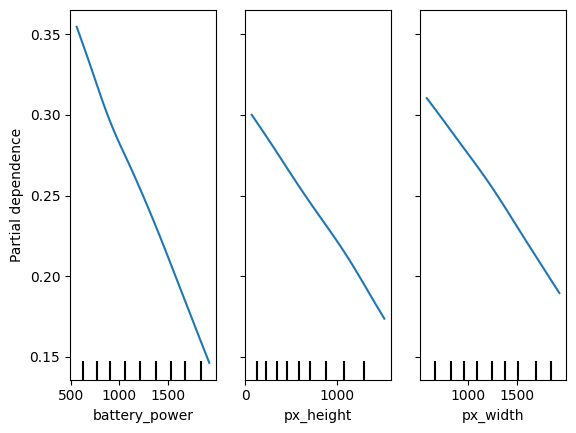

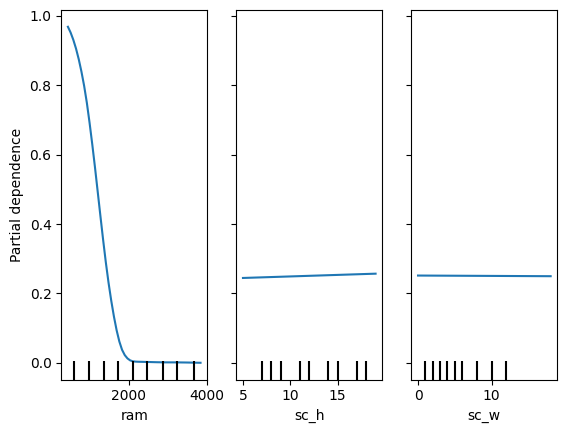

In [ ]:
target_class = 0
feature_index1 = [0, 11, 12] 
display = PartialDependenceDisplay.from_estimator(svm, X_train, features=feature_index1, grid_resolution=50, target=target_class)

feature_index2 = [13, 14, 15]
display = PartialDependenceDisplay.from_estimator(svm, X_train, features=feature_index2, grid_resolution=50, target=target_class)

In [ ]:
# import shap
# import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split


# # Utworzenie modelu
# svm = SVC(kernel='linear', probability=True)
# svm.fit(X_train, y_train)

# #explainer = shap.Explainer(svm)
# explainer = shap.KernelExplainer(svm.predict_proba, X_train)

# shap_values = explainer.shap_values(X_val)

# shap.summary_plot(shap_values, X_val)
